In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import math
import json
from collections import Counter
import matplotlib.pyplot as plt

# 初始化 Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-yuxinchen118')


In [2]:

# 定义研究区域（上海）
center_lat, center_lon = 31.3304, 121.5737
km_to_deg_lat = 1 / 111.32
km_to_deg_lon = 1 / (111.32 * math.cos(math.radians(center_lat)))
lat_extent = 40 * km_to_deg_lat
lon_extent = 50 * km_to_deg_lon
shanghai_region = ee.Geometry.Rectangle([
    center_lon - lon_extent / 2,
    center_lat - lat_extent / 2,
    center_lon + lon_extent / 2,
    center_lat + lat_extent / 2
])

# 加载 Sentinel-2 图像并添加指数
image_id = "20220227T023639_20220227T024821_T51RUQ"
sentinel_image = ee.Image("COPERNICUS/S2_SR/" + image_id)
selected_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
image = sentinel_image.select(selected_bands).clip(shanghai_region)
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')
bsi = image.expression(
    '((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))',
    {'B11': image.select('B11'), 'B4': image.select('B4'),
     'B8': image.select('B8'), 'B2': image.select('B2')}
).rename('BSI')
composite = image.addBands([ndvi, ndwi, ndbi, bsi])
all_bands = selected_bands + ['NDVI', 'NDWI', 'NDBI', 'BSI']

# 加载训练和验证数据
train_df = pd.read_csv('SH_pixels_training_data.csv')
valid_df = pd.read_csv('SH_pixels_validation_data.csv')

# DataFrame 转为 FeatureCollection
def df_to_fc(df):
    features = []
    for _, row in df.iterrows():
        geom = ee.Geometry.Point(json.loads(row['.geo'])['coordinates'])
        props = {key: row[key] for key in all_bands + ['class']}
        features.append(ee.Feature(geom, props))
    return ee.FeatureCollection(features)

train_fc = df_to_fc(train_df)
valid_fc = df_to_fc(valid_df)


In [3]:
# 创建 KMeans 分类器并应用于 composite
clusterer = ee.Clusterer.wekaKMeans(5).train(composite.sampleRegions(
    collection=train_fc,
    scale=10,
    geometries=False
))
classified = composite.cluster(clusterer)

In [4]:
# 改进方案1: 更稳定的重映射策略
def get_improved_remap_dict(clustered_fc, min_confidence=0.6):
    """
    基于置信度的重映射，只有当多数类别占比超过阈值时才映射
    """
    clustered_info = clustered_fc.select(['cluster', 'class']).getInfo()
    pairs = [(f['properties']['cluster'], f['properties']['class']) for f in clustered_info['features']]
    
    mapping = {}
    for cid in set(k for k, _ in pairs):
        labels = [cls for k, cls in pairs if k == cid]
        label_counts = Counter(labels)
        total = len(labels)
        
        if total > 0:
            majority_label, majority_count = label_counts.most_common(1)[0]
            confidence = majority_count / total
            
            # 只有当置信度足够高时才进行映射
            if confidence >= min_confidence:
                mapping[cid] = majority_label
            else:
                print(f"⚠️ 聚类 {cid} 置信度不足 ({confidence:.3f}), 跳过映射")
                # 可以选择映射到最不确定的类别或进行其他处理
                mapping[cid] = majority_label  # 暂时还是映射到多数类
    
    return mapping

# 改进方案2: 使用训练集和验证集联合映射
def get_combined_remap_dict(train_clustered, valid_clustered, weight_train=0.7):
    """
    结合训练集和验证集的映射结果
    """
    def get_cluster_stats(clustered_fc):
        clustered_info = clustered_fc.select(['cluster', 'class']).getInfo()
        pairs = [(f['properties']['cluster'], f['properties']['class']) for f in clustered_info['features']]
        
        stats = {}
        for cid in set(k for k, _ in pairs):
            labels = [cls for k, cls in pairs if k == cid]
            stats[cid] = Counter(labels)
        return stats
    
    train_stats = get_cluster_stats(train_clustered)
    valid_stats = get_cluster_stats(valid_clustered)
    
    mapping = {}
    all_clusters = set(train_stats.keys()) | set(valid_stats.keys())
    
    for cid in all_clusters:
        combined_counts = Counter()
        
        # 加权合并训练集和验证集的统计
        if cid in train_stats:
            for label, count in train_stats[cid].items():
                combined_counts[label] += count * weight_train
        
        if cid in valid_stats:
            for label, count in valid_stats[cid].items():
                combined_counts[label] += count * (1 - weight_train)
        
        if combined_counts:
            mapping[cid] = combined_counts.most_common(1)[0][0]
    
    return mapping

# 改进方案3: 优化特征组合
def create_optimized_composite(image):
    """
    创建优化的特征组合
    """
    # 基础波段
    selected_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
    base_image = image.select(selected_bands)
    
    # 植被指数
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    evi = image.expression(
        '2.5 * ((B8 - B4) / (B8 + 6 * B4 - 7.5 * B2 + 1))',
        {'B8': image.select('B8'), 'B4': image.select('B4'), 'B2': image.select('B2')}
    ).rename('EVI')
    
    # 水体指数
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    mndwi = image.normalizedDifference(['B3', 'B11']).rename('MNDWI')
    
    # 建筑指数
    ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')
    ui = image.expression(
        '(B11 - B8) / (B11 + B8)',
        {'B11': image.select('B11'), 'B8': image.select('B8')}
    ).rename('UI')
    
    # 裸土指数
    bsi = image.expression(
        '((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))',
        {'B11': image.select('B11'), 'B4': image.select('B4'),
         'B8': image.select('B8'), 'B2': image.select('B2')}
    ).rename('BSI')
    
    # 组合所有特征
    composite = base_image.addBands([ndvi, evi, ndwi, mndwi, ndbi, ui, bsi])
    return composite

# 改进方案4: 使用不同的聚类算法
def create_cascade_classifier(composite, train_fc, n_clusters=8):
    """
    级联分类：先粗分类，再细分类
    """
    # 第一级：粗分类（水体 vs 非水体）
    water_clusterer = ee.Clusterer.wekaKMeans(2).train(
        composite.select(['NDWI', 'MNDWI', 'B3', 'B8']).sampleRegions(
            collection=train_fc,
            scale=10,
            geometries=False
        )
    )
    
    # 第二级：细分类
    main_clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(
        composite.sampleRegions(
            collection=train_fc,
            scale=10,
            geometries=False
        )
    )
    
    return main_clusterer

# 主要改进实现
print("🔄 应用改进的重映射策略...")

# 1. 创建优化的特征组合
optimized_composite = create_optimized_composite(sentinel_image.clip(shanghai_region))

# 2. 使用更多聚类数
n_clusters = 8  # 增加聚类数，后续合并
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(
    optimized_composite.sampleRegions(
        collection=train_fc,
        scale=10,
        geometries=False
    )
)

classified = optimized_composite.cluster(clusterer)

# 3. 获取训练集和验证集的聚类结果
train_clustered = optimized_composite.sampleRegions(
    collection=train_fc,
    scale=10,
    geometries=False
).cluster(clusterer)

valid_clustered = optimized_composite.sampleRegions(
    collection=valid_fc,
    scale=10,
    geometries=False
).cluster(clusterer)

# 4. 使用改进的映射策略
remap_dict = get_combined_remap_dict(train_clustered, valid_clustered, weight_train=0.8)
print("✅ 改进的 cluster-to-class 映射:", remap_dict)

# 5. 应用重映射
from_ids = list(remap_dict.keys())
to_ids = list(remap_dict.values())
classified_remapped = classified.remap(from_ids, to_ids).rename('classification')


print("🎯 分类完成！建议进一步调整：")
print("1. 根据混淆矩阵结果调整特征组合")
print("2. 尝试不同的聚类数量")
print("3. 考虑使用监督分类方法")
print("4. 增加更多训练样本")

🔄 应用改进的重映射策略...
✅ 改进的 cluster-to-class 映射: {0: 4, 1: 2, 2: 3, 3: 1, 4: 0, 5: 0, 6: 3, 7: 2}
🎯 分类完成！建议进一步调整：
1. 根据混淆矩阵结果调整特征组合
2. 尝试不同的聚类数量
3. 考虑使用监督分类方法
4. 增加更多训练样本


In [5]:

# 显示地图
color_scheme = {
    'water': '#419BDF', 'trees': '#397D49',
    'crops': '#E49635', 'built': '#C4281B', 'bare': '#A59B8F'
}
classes = ['water', 'trees', 'crops', 'built', 'bare']
palette = [color_scheme[c] for c in classes]

Map = geemap.Map(center=[31.3, 121.5], zoom=10)
Map.addLayer(classified, {'min': 0, 'max': 4, 'palette': palette}, 'KMeans')
Map.addLayer(classified_remapped, {'min': 0, 'max': 4, 'palette': palette}, 'KMeans Remapped')
Map.add_legend(title="Land Cover Types", legend_dict=color_scheme)
Map


Map(center=[31.3, 121.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [10]:
import ee
from pathlib import Path

def export_shanghai_classification(classified):
 

    # 2. 裁剪并转换为整数类型（用于 GeoTIFF 导出）
    classified_clipped = classified.clip(shanghai_region).byte()

    # 3. 创建导出任务
    task = ee.batch.Export.image.toDrive(
        image=classified_remapped,          
        description='shanghai_kmeans_classification_raw',
        folder='Mapresult',       # Drive 文件夹名
        fileNamePrefix='Shanghai_KMeans_Classification',  # 文件名前缀
        region=shanghai_region,
        scale=30,
        crs='EPSG:4326',
        fileFormat='GeoTIFF',
        maxPixels=1e9
    )

    # 4. 启动任务
    task.start()
    print("✅ 导出任务已启动！请稍候检查 Google Drive 中的 EarthEngine_Exports 文件夹。")
    return task

# ✅ 调用函数
export_task = export_shanghai_classification(classified)


✅ 导出任务已启动！请稍候检查 Google Drive 中的 EarthEngine_Exports 文件夹。


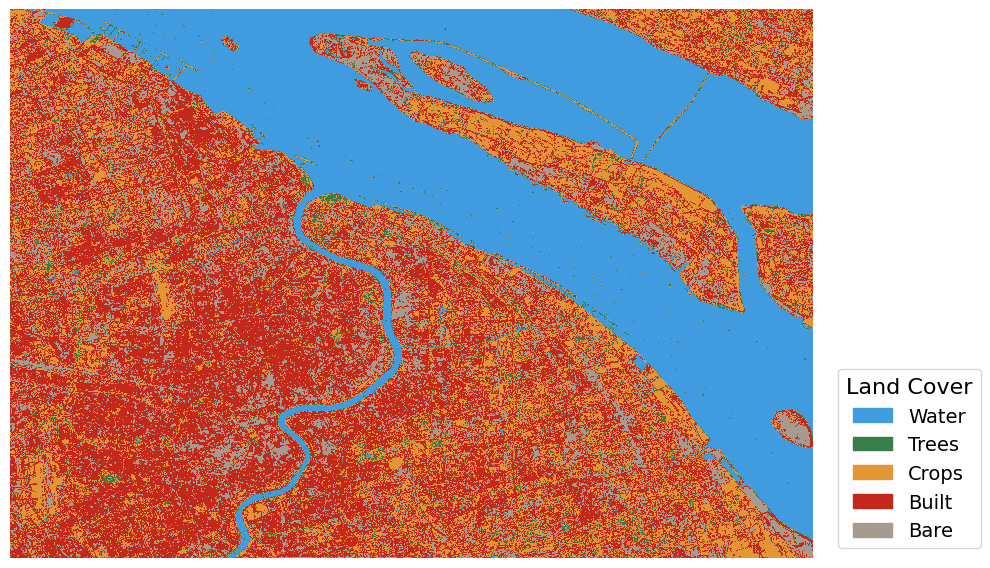

In [11]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# 类别颜色定义
color_scheme = {
    'Water': '#419BDF',
    'Trees': '#397D49',
    'Crops': '#E49635',
    'Built': '#C4281B',
    'Bare': '#A59B8F'
}
palette = list(color_scheme.values())
classes = list(color_scheme.keys())

# 读取 KMeans 分类 tif
with rasterio.open('Shanghai_KMeans_Classification.tif') as src:
    rf_image = src.read(1)

# 绘图
plt.figure(figsize=(10, 10))
cmap = plt.matplotlib.colors.ListedColormap(palette)
plt.imshow(rf_image, cmap=cmap, vmin=0, vmax=4)
plt.axis('off')

# 图例右下角外部
legend_patches = [Patch(color=palette[i], label=classes[i]) for i in range(len(classes))]
plt.legend(
    handles=legend_patches,
    title="Land Cover",
    loc='lower left',
    bbox_to_anchor=(1.02, 0),
    frameon=True,
    fontsize=14,
    title_fontsize=16
)

plt.tight_layout()
plt.savefig("Shanghai_KMeans_Classification_with_Legend.png", dpi=300, bbox_inches='tight')
plt.show()

Validation Accuracy: 0.883245382585752
Confusion Matrix:
[[320   0   0   0   0]
 [  0 261   3  36   3]
 [  0   8 268   3  10]
 [  0   7  22 228  30]
 [  0   0   5  50 262]]


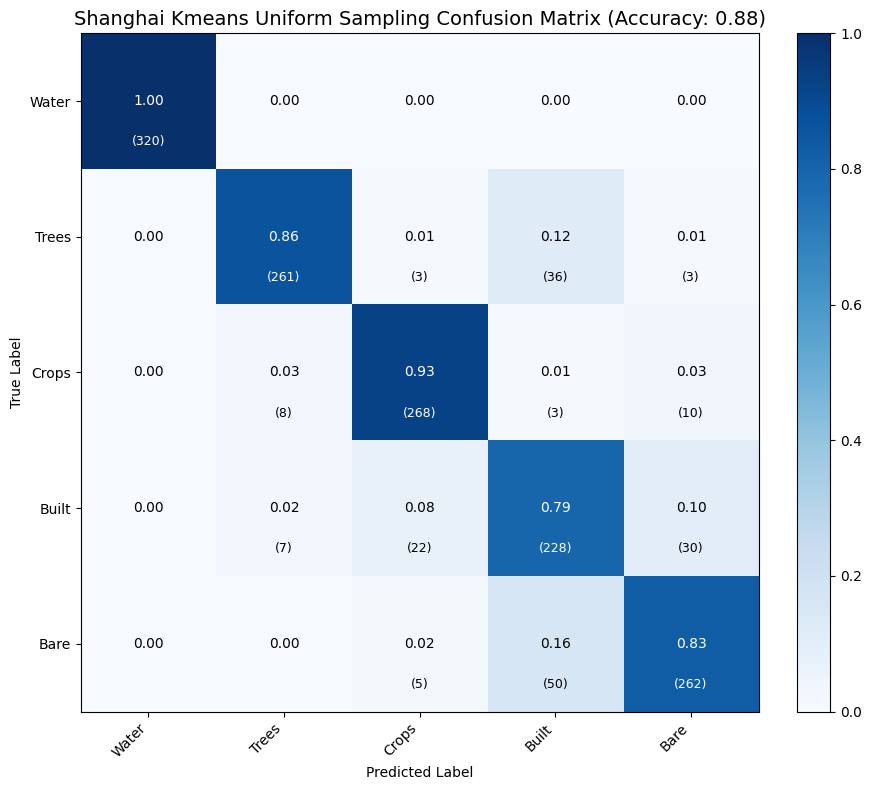


📊 Accuracy Report
Class		PA		UA
Water     	1.00		1.00
Trees     	0.86		0.95
Crops     	0.93		0.90
Built     	0.79		0.72
Bare      	0.83		0.86

✅ Overall Accuracy: 0.88
✅ Kappa Coefficient: 0.85


In [8]:
# 验证集分类
val_data = classified_remapped.sampleRegions(
    collection=valid_fc,
    properties=['class'],
    scale=10,
    geometries=False
)
confusion_matrix = val_data.errorMatrix('class', 'classification')
print("Validation Accuracy:", confusion_matrix.accuracy().getInfo())
print("Confusion Matrix:")
print(np.array(confusion_matrix.array().getInfo()))

# 可视化混淆矩阵
def plot_ee_confusion_matrix(confusion_matrix, class_names=None):
    cm_array = np.array(confusion_matrix.array().getInfo())
    accuracy = confusion_matrix.accuracy().getInfo()
    if class_names is None:
        class_names = [str(i) for i in range(cm_array.shape[0])]
    cm_normalized = np.zeros(cm_array.shape)
    for i in range(cm_array.shape[0]):
        row_sum = np.sum(cm_array[i, :])
        if row_sum > 0:
            cm_normalized[i, :] = cm_array[i, :] / row_sum
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm_normalized, cmap='Blues', vmin=0, vmax=1)
    ax.set_title(f'Shanghai Kmeans Uniform Sampling Confusion Matrix (Accuracy: {accuracy:.2f})', fontsize=14)
    ax.set_ylabel('True Label'), ax.set_xlabel('Predicted Label')
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names), ax.set_yticklabels(class_names)
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, f"{cm_normalized[i, j]:.2f}",
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > 0.5 else "black")
            if cm_array[i, j] > 0:
                ax.text(j, i + 0.3, f"({int(cm_array[i, j])})",
                        ha="center", va="center",
                        color="white" if cm_normalized[i, j] > 0.5 else "black",
                        fontsize=9)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    fig.tight_layout()
    return fig, ax

# 设置类别名称
class_names = ['Water', 'Trees', 'Crops', 'Built', 'Bare']
plot_ee_confusion_matrix(confusion_matrix, class_names)
plt.show()

# 计算 PA, UA, OA, Kappa
def compute_accuracies(conf_matrix):
    cm = np.array(conf_matrix.array().getInfo())
    total = cm.sum()
    actual = cm.sum(axis=1)
    predicted = cm.sum(axis=0)
    correct = np.diag(cm)
    PA = correct / actual
    UA = correct / predicted
    OA = correct.sum() / total
    expected = np.dot(actual, predicted) / (total ** 2)
    kappa = (OA - expected) / (1 - expected)
    return PA, UA, OA, kappa

PA, UA, OA, kappa = compute_accuracies(confusion_matrix)

print("\n📊 Accuracy Report")
print("Class\t\tPA\t\tUA")
for i, class_name in enumerate(class_names):
    print(f"{class_name:<10}\t{PA[i]:.2f}\t\t{UA[i]:.2f}")
print(f"\n✅ Overall Accuracy: {OA:.2f}")
print(f"✅ Kappa Coefficient: {kappa:.2f}")


